In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import yfinance as yf


In [12]:
import seaborn as sns
sns.set_style("darkgrid")

Resources used: https://medium.com/@prajjwalchauhan94017/stock-prediction-and-forecasting-using-lstm-long-short-term-memory-9ff56625de73

# Importing Data

In [15]:
# get amz.de stock data hourly from yahoo finance for last 6 months
def get_stock_data(ticker, start_date, end_date, interval):
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    # save stock data to csv with ticker, start_date, end_date, interval informations if there is no error
    if len(stock_data) == 0:
        print('No data found, please check the ticker, start_date, end_date, interval')
    else:
        stock_data.to_csv(f'data/{ticker}_{start_date}_{end_date}_{interval}.csv')
    return stock_data

In [70]:
# Get stock data for amz.de for last 6 months hourly
stock_data = get_stock_data('AMZ.DE', '2021-10-13', '2024-10-13', '1d')

[*********************100%%**********************]  1 of 1 completed


In [112]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-13,140.500000,141.774994,140.175003,141.050003,141.050003,31120
2021-10-14,142.425003,142.824997,141.925003,142.600006,142.600006,31240
2021-10-15,142.699997,146.199997,142.324997,145.550003,145.550003,43540
2021-10-18,146.550003,148.149994,145.824997,147.199997,147.199997,64540
2021-10-19,148.250000,148.425003,147.024994,147.475006,147.475006,65620


In [118]:
# Run this cell if you have already downloaded the data
stock_data = pd.read_csv('data\AMZ.DE_2023-10-13_2024-10-13_1h.csv', index_col=0)

<Axes: xlabel='Datetime'>

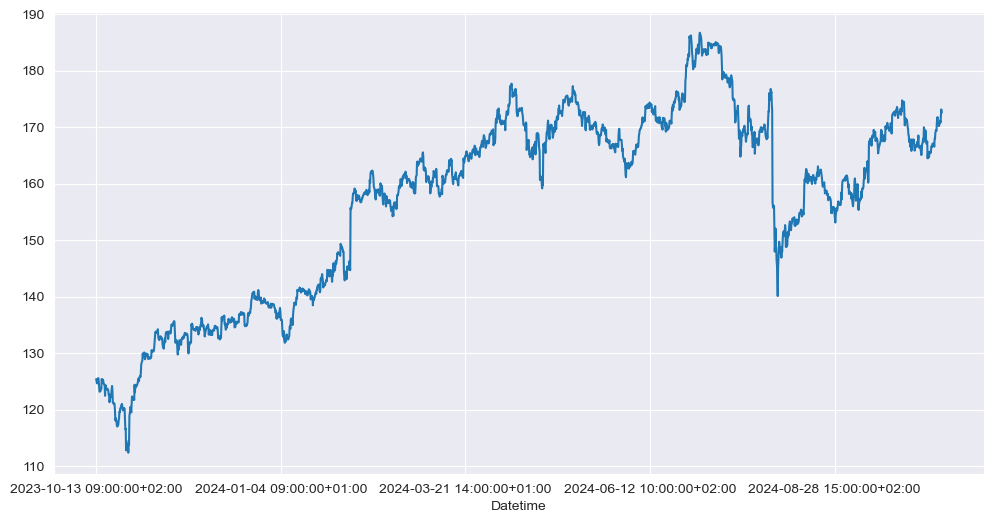

In [135]:
df_1 = stock_data.copy()
#df_1.set_index('Datetime', inplace=True)
df_1.Close.plot(figsize=(12, 6))

# Preprocessing

In [141]:
#df_1.reset_index(inplace=True)
df_1['Datetime'] = pd.to_datetime(df_1['Datetime'], utc=True)

In [150]:
df_1['Datetime'].dt.day_name()

0       Friday
1       Friday
2       Friday
3       Friday
4       Friday
         ...  
2286    Friday
2287    Friday
2288    Friday
2289    Friday
2290    Friday
Name: Datetime, Length: 2291, dtype: object

In [152]:
df_1

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-10-13 07:00:00+00:00,125.360001,125.559998,125.239998,125.440002,125.440002,5164
1,2023-10-13 08:00:00+00:00,125.440002,125.500000,124.800003,125.019997,125.019997,16324
2,2023-10-13 09:00:00+00:00,125.040001,125.040001,124.680000,124.680000,124.680000,9830
3,2023-10-13 10:00:00+00:00,124.680000,124.820000,124.540001,124.699997,124.699997,10806
4,2023-10-13 11:00:00+00:00,124.760002,125.160004,124.760002,125.120003,125.120003,6568
...,...,...,...,...,...,...,...
2286,2024-10-11 11:00:00+00:00,170.759995,171.220001,170.740005,171.199997,171.199997,2100
2287,2024-10-11 12:00:00+00:00,171.059998,171.300003,170.860001,170.860001,170.860001,2150
2288,2024-10-11 13:00:00+00:00,170.940002,172.059998,170.440002,171.899994,171.899994,9888
2289,2024-10-11 14:00:00+00:00,172.080002,173.479996,171.880005,173.179993,173.179993,17334


In [151]:
# Exclude weekends from df_1
df_1['day'] = df_1['Datetime'].dt.day_name()
df_1 = df_1[(df_1.day != 'Saturday') & (df_1.day != 'Sunday')]
df_1.drop('day', axis=1, inplace=True)

In [153]:
# Scale down data to 0-1
scaler = MinMaxScaler()
df_2 = scaler.fit_transform(np.array(df_1[['Close']]).reshape(-1,1))
df_2.shape 

(2291, 1)

In [156]:
# Train test split
train_size = int(len(df_2) * 0.75)
test_size = len(df_2) - train_size
train_data, test_data = df_2[0:train_size,:], df_2[train_size:len(df_2),:]

In [314]:
def create_dataset(dataset, time_step = 1):
    '''A function is created as create_dataset() which splits the dataset into 2 based on the time step we take. 
    The first dataset i.e.; dataX takes the values as its input and the second dataset dataY takes the values as output'''
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [315]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 20
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [323]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(1698, 20)
[[0.17536313 0.16971485 0.16514255 ... 0.16971485 0.17428726 0.17213551]
 [0.16971485 0.16514255 0.16541147 ... 0.17428726 0.17213551 0.16568048]
 [0.16514255 0.16541147 0.17105974 ... 0.17213551 0.16568048 0.16352874]
 ...
 [0.91635285 0.88891884 0.90156008 ... 0.88649828 0.89268429 0.88596024]
 [0.88891884 0.90156008 0.9018291  ... 0.89268429 0.88596024 0.87547075]
 [0.90156008 0.9018291  0.9064014  ... 0.88596024 0.87547075 0.86982257]]
(553, 20)
(553,)


In [183]:
# Push data to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
Y_test = torch.from_numpy(Y_test).float().to(device)

In [187]:
(X_train.shape[1],1)

(20, 1)

In [324]:
# Assuming you already have a function to create datasets like in the original code
time_step = 20
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Push data to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
Y_test = torch.from_numpy(Y_test).float().to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = self.fc(out)  # Take the last time step's output
        return out

# Initialize the model
input_size = X_train.shape[1]  # Input feature size (since it's univariate time series, it's 1)
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
batch_size = 32

def train_model(model, X_train, Y_train, num_epochs, batch_size):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the mini-batch
            inputs = X_train[i:i+batch_size]
            labels = Y_train[i:i+batch_size]

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.to(device)

# Train the model
train_model(model, X_train, Y_train, num_epochs, batch_size)

c:\Users\esual\miniconda3\envs\venvBjk\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\esual\miniconda3\envs\venvBjk\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [1/100], Loss: 0.3952
Epoch [2/100], Loss: 0.2817
Epoch [3/100], Loss: 0.1725
Epoch [4/100], Loss: 0.1149
Epoch [5/100], Loss: 0.0808
Epoch [6/100], Loss: 0.0421
Epoch [7/100], Loss: 0.0129
Epoch [8/100], Loss: 0.0031
Epoch [9/100], Loss: 0.0003
Epoch [10/100], Loss: 0.0005
Epoch [11/100], Loss: 0.0003
Epoch [12/100], Loss: 0.0005
Epoch [13/100], Loss: 0.0005
Epoch [14/100], Loss: 0.0005
Epoch [15/100], Loss: 0.0006
Epoch [16/100], Loss: 0.0006
Epoch [17/100], Loss: 0.0006
Epoch [18/100], Loss: 0.0007
Epoch [19/100], Loss: 0.0007
Epoch [20/100], Loss: 0.0007
Epoch [21/100], Loss: 0.0007
Epoch [22/100], Loss: 0.0008
Epoch [23/100], Loss: 0.0008
Epoch [24/100], Loss: 0.0008
Epoch [25/100], Loss: 0.0008
Epoch [26/100], Loss: 0.0008
Epoch [27/100], Loss: 0.0009
Epoch [28/100], Loss: 0.0009
Epoch [29/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0009
Epoch [31/100], Loss: 0.0009
Epoch [32/100], Loss: 0.0009
Epoch [33/100], Loss: 0.0009
Epoch [34/100], Loss: 0.0009
Epoch [35/100], Loss: 0

In [325]:
with torch.no_grad():
    # Predictions for training and test sets
    train_predict = model(X_train)
    test_predict = model(X_test)

    # Convert predictions and true values back to original scale
    train_predict = train_predict.cpu().numpy()
    test_predict = test_predict.cpu().numpy()
    
    # Assuming 'scaler' is already defined as in the original code
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)


In [327]:
look_back = 20
trainPredictPlot = np.empty_like(df_2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df_2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2: len(df_2),:] = test_predict

In [328]:
testPredictPlot

array([[         nan],
       [         nan],
       [         nan],
       ...,
       [174.40577698],
       [174.6491394 ],
       [174.97438049]])

In [335]:
%matplotlib qt5

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_2), label='Actual Value')
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Test')
plt.legend()
plt.show()

In [336]:
import plotly.graph_objs as go
import plotly.express as px

%matplotlib qt5

# Create the interactive plot
fig = go.Figure()

# Add the 'Actual Value' plot with markers
fig.add_trace(go.Scatter(
    y=scaler.inverse_transform(df_2).flatten(),  # Flatten in case of a 2D array
    mode='lines+markers',  # Line with markers
    marker=dict(symbol='circle', size=6),  # Customize the marker shape and size
    name='Actual Value'
))

# Add the 'Train' plot with markers
fig.add_trace(go.Scatter(
    y=trainPredictPlot.flatten(),  # Assuming it's already inverse transformed and flattened
    mode='lines+markers',  # Line with markers
    marker=dict(symbol='circle', size=6),  # Customize the marker shape and size
    name='Train'
))

# Add the 'Test' plot with markers
fig.add_trace(go.Scatter(
    y=testPredictPlot.flatten(),  # Assuming it's already inverse transformed and flattened
    mode='lines+markers',  # Line with markers
    marker=dict(symbol='circle', size=6),  # Customize the marker shape and size
    name='Test'
))

# Customize the layout of the figure
fig.update_layout(
    title="Predicted vs Actual Values",
    xaxis_title="Time Steps",
    yaxis_title="Value",
    legend_title="Data",
    width=900,
    height=500
)

# Show the interactive plot
#fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'size': 6, 'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'Actual Value',
              'type': 'scatter',
              'y': array([125.44000244, 125.01999664, 124.68000031, ..., 171.8999939 ,
                          173.17999268, 172.58000183])},
             {'marker': {'size': 6, 'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'Train',
              'type': 'scatter',
              'y': array([nan, nan, nan, ..., nan, nan, nan])},
             {'marker': {'size': 6, 'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': 'Test',
              'type': 'scatter',
              'y': array([         nan,          nan,          nan, ..., 174.40577698,
                          174.6491394 , 174.97438049])}],
    'layout': {'height': 500,
               'legend': {'title': {'text': 'Data'}},
               'template': '...',
               'title': {'text': 'Predicted vs Actual Values'},
               'width': 900,
               'xaxis': {'title': {'text': 'Time Steps'}},
               'yaxis': {'title': {'text': 'Value'}}}
})

In [239]:
train_predict_plot

array([0., 0., 0., ..., 0., 0., 0.])

In [240]:
df_1['Close']

0       125.440002
1       125.019997
2       124.680000
3       124.699997
4       125.120003
           ...    
2286    171.199997
2287    170.860001
2288    171.899994
2289    173.179993
2290    172.580002
Name: Close, Length: 2291, dtype: float64

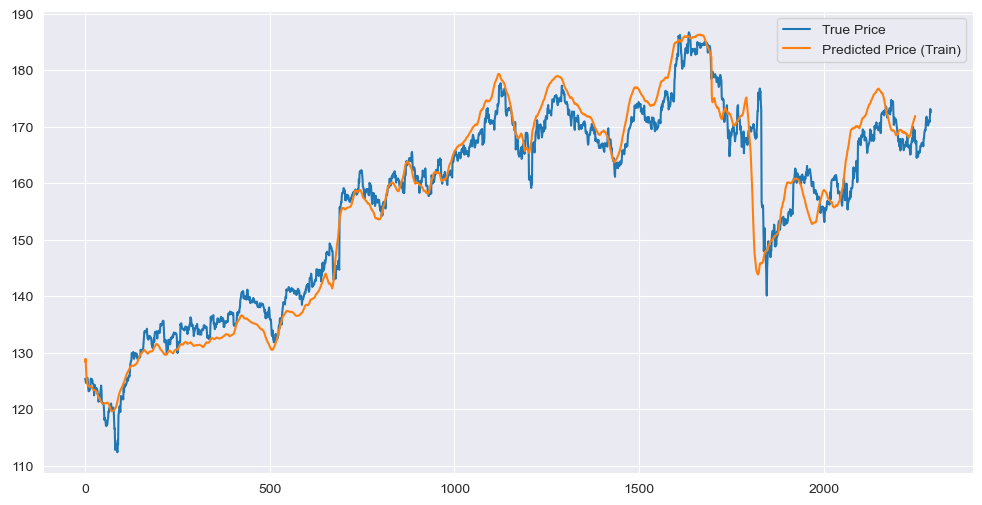

In [244]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_1['Close'], label='True Price')
plt.plot(train_predict_plot[21:-21], label='Predicted Price (Train)')
plt.legend()
plt.show()

In [245]:
# Calculate the RMSE
train_rmse = np.sqrt(mean_squared_error(df_1['Close'][21:train_size], train_predict.reshape(-1)))
test_rmse = np.sqrt(mean_squared_error(df_1['Close'][train_size:-21], test_predict.reshape(-1)))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 3.64
Test RMSE: 3.63


In [246]:
# Calculate accuracy
train_accuracy = 100 - (train_rmse / df_1['Close'][21:train_size].mean()) * 100
test_accuracy = 100 - (test_rmse / df_1['Close'][train_size:-21].mean()) * 100
print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

Train Accuracy: 97.65%
Test Accuracy: 97.78%
